In [1]:
#Importing libraries
import gurobipy as gp
from gurobipy import *
import pandas as pd
import numpy as np

##### Assumptions

In [2]:
#Defining how we can split land
land = ['1_yr_rotn', '3_yr_rotn']

#Crops in selection bucket for 1-year and 3-year rotation
cycle_1 = ['cotton', 'oats', 'wheat', 'barley', 'rice' ]
cycle_3 = ['wheat', 'cotton', 'oats', 'corn', 'barley', 'rice']

#Total acres of land to be planned for
acres = 10

#Setting budget restrictions
seeds_budget = 150*acres
fertilizer_budget = 200*acres

#Plan to be developed for pre-defined years
years = 10

#Minimum no. of crops to be selected for each type of rotation
no_1_year_crops = 1
no_3_year_crops = 2

##### Input data as obtained from reliable source eg. USDA

In [3]:
#Seed costs split as per crops for 1-year and 3-years rotation
seed_1 = [17.86, 8.51, 7.51, 10.48, 24.17]
seed_3 = [7.51, 17.86, 8.51, 27.59, 10.48, 24.17]

#Fertilizer costs split as per crops for 1-year and 3-years rotation
fertilizer_1 = [37.96, 10.03, 18.59, 12.79, 45.93]
fertilizer_3 = [18.59, 37.96, 10.03, 51.47, 12.79, 45.93]

#Yields split as per crops for 1-year and 3-years rotation
yields_1 = [13.75, 61.3, 37.1, 77.2, 126.98]
yields_3 = [37.1, 13.75, 61.3, 176.5, 77.2, 126.98]

#Selling Price as per crops for 1-year and 3-years rotation
selling_price_1 = [137.71, 419.04, 125.12, 304.23, 493.53]
selling_price_3 = [125.12, 137.71, 419.04, 847.73, 304.23, 493.53]



In [4]:
len_cycle_1 = len(cycle_1)
len_cycle_3 = len(cycle_3)

In [5]:
#Intiating the model
model = Model("Team 15 - Crop Selection")

Restricted license - for non-production use only - expires 2022-01-13


##### Adding decision variables

- **Choice_1 :**
    - A matrix of binary variables of dimensions (years*no._of_crops_considered_for_1-year_rotation)
    - This matrix essentially shows if a particular crop will be grown in a particular year.



- **Choice_3 :**
    - A matrix of binary variables of dimensions (years*no._of_crops_considered_for_3-year_rotation)
    - This matrix essentially shows if a particular crop will be grown in a particular year.  



           
- **profit_1 :**
    - A 1-D matrix of continuous variables of length similar to number of years.
    - This matrix captures the profit for each year as contributed by crops following the 1-year rotation.
    
    
 
- **profit_3 :**
    - A 1-D matrix of continuous variables of length similar to number of years.
    - This matrix captures the profit for each year as contributed by crops following the 3-year rotation.
    
 
           
- **land_devoted :**
    - A 1-D matrix of continuous variables of length similar to number of years.
    - This matrix records the land alloted to crops following 1-year rotation and 3-year rotation respectively.
    - In case of multiple crops grown under any of the pattern, land is assumed to divided equally to the crops under                  that pattern.

In [6]:
choice_1 = model.addVars(years,len_cycle_1, vtype = GRB.BINARY, name = ["choice_1_yr_"+str(i+1)+"_crop_"+j for i in range(years) for j in cycle_1])
choice_3 = model.addVars(years,len_cycle_3, vtype = GRB.BINARY, name = ["choice_3_yr_"+str(i+1)+"_crop_"+j for i in range(years) for j in cycle_3])
profit_1 = model.addVars(years, vtype = GRB.CONTINUOUS, name = ["profit_1_"+str(i+1) for i in range(years)])
profit_3 = model.addVars(years, vtype = GRB.CONTINUOUS, name = ["profit_3_"+str(i+1) for i in range(years)])
land_devoted = model.addVars(years, len(land), lb=acres/10, vtype = GRB.CONTINUOUS, name = ["land_devoted_"+j+"_year_"+str(i+1) for i in range(years) for j in land])

##### Adding constraints on model

Constraint 1: Fertilizer budget <br>
Constraint 2: Seeds' budget <br>
Constraint 3: Limit on no. of crops for a 1-year rotation  <br>
Constraint 4: Limit on no. of crops for a 3-year rotation <br>
Constraint 5: Max limit on no. of crops to be planted overall <br>
Constarint 6: Land devoted to the crops should be less than the farm size


In [7]:
for i in range(years):
    
    model.addConstr(sum(choice_1[i,j]*fertilizer_1[j]*land_devoted[i,0] for j in range(len(fertilizer_1)))+sum(choice_3[i,k]*fertilizer_3[k]*land_devoted[i,1] for k in range(len(fertilizer_3)))<=fertilizer_budget, name="fertilizer_budget_year_"+str(i+1))
    model.addConstr(sum(choice_1[i,j]*seed_1[j]*land_devoted[i,0] for j in range(len(seed_1)))+sum(choice_3[i,k]*seed_3[k]*land_devoted[i,1] for k in range(len(seed_3)))<=seeds_budget, name="seed_budget_year_"+str(i+1))
    model.addConstr(sum(choice_1[i,j] for j in range(len_cycle_1))>=no_1_year_crops, name="selection_limit_1_year_"+str(i+1))
    model.addConstr(sum(choice_3[i,j] for j in range(len_cycle_3))>=no_3_year_crops, name="selection_limit_3_year_"+str(i+1))
    model.addConstr(sum(choice_1[i,j]*land_devoted[i,0] for j in range(len(cycle_1)))+sum(choice_3[i,k]*land_devoted[i,1] for k in range(len(cycle_3)))<=acres, name="land_devoted_limit"+str(i+1))
    model.addConstr(sum(land_devoted[i,j] for j in range(len(land)))<=acres, name="land_limit_3_year_"+str(i+1))

Constraint 7: Corn to be preceded by Wheat

In [8]:

for i in range(1,years):
    model.addConstr(choice_3[i, 3]<=choice_3[i-1, 0], name="corn-wheat_"+str(i))

Constraint 8: Same crop cannot be planted in the 1-year rotation plan as well as the 3-year rotation plan <br>

In [9]:
a=[]

for j in range(len(cycle_1)):
    for k in range(len(cycle_3)):
        if cycle_1[j]==cycle_3[k]:
            if cycle_1[j] not in a:
                a.append(cycle_1[j])
                for i in range(years):
                    model.addConstr(choice_1[i,j]+choice_3[i,k]<=1, name="No Two crops"+str(i)+"_"+str(j)+"_"+str(k))
    


Constraint 9: Limit on planting the same crop for a 1-year rotation cycle in 10 years<br>
Constraint 10: Limit on planting consecutive crops for a 1-year cycle rotation <br>
Constraint 11: Limit on planting the same crop for a 3-year rotation cycle in 10 years <br>
Constraint 12: Limit on planting consecutive crops for a 3-year cycle rotation<br>

In [10]:
for i in range(len_cycle_1):
    model.addConstr(sum(choice_1[j,i] for j in range(years))<=3, name="growth_limit_1_crop_"+str(i))
    for j in range(0, (years-1)):
        model.addConstr(choice_1[j,i]+choice_1[j+1,i]<=1, name="consecutive_1_crop_"+str(i)+"_Year_"+str(j))
for i in range(len_cycle_3):
    model.addConstr(sum(choice_3[j,i] for j in range(years))<=4, name="growth_limit_3_crop_"+str(i))
    for j in range(0, (years-2)):
        model.addConstr(choice_3[j,i]+choice_3[j+1,i]+choice_3[j+2,i]<=1, name="consecutive_3_crop_"+str(i)+"_Year_"+str(j))

##### Constraints on objective

Constraint 13: Profit earned from a 1-year cycle rotation <br>
Constraint 14: Profit earned from a 3-year cycle rotation <br>

In [11]:
 
for i in range(years):
    model.addConstr(sum(choice_1[i,j]*selling_price_1[j]*yields_1[j]*land_devoted[i,0] for j in range(len_cycle_1)) == profit_1[i], name="profit_1_"+str(i))
    model.addConstr(sum(choice_3[i,j]*selling_price_3[j]*yields_3[j]*land_devoted[i,1] for j in range(len_cycle_3)) == profit_3[i], name="profit_3_"+str(i))

In [12]:
#Setting the objective
objective = sum(profit_1[i]+profit_3[i] for i in range(years))
model.setObjective(objective, GRB.MAXIMIZE)

In [13]:
model.params.NonConvex = 2
model.setParam(GRB.Param.PoolSearchMode, 2)
model.Params.TimeLimit = 720
model.optimize()

Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter PoolSearchMode to 2
   Prev: 0  Min: 0  Max: 2  Default: 0
Changed value of parameter TimeLimit to 720.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 193 rows, 150 columns and 592 nonzeros
Model fingerprint: 0x053f5a99
Model has 50 quadratic constraints
Variable types: 40 continuous, 110 integer (110 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+05]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
  QRHS range       [1e+01, 2e+03]
Presolve removed 6 rows and 0 columns
Presolve time: 0.14s
Presolved: 557 rows, 260 columns, 1982 nonzeros
Variable types: 150 continuous, 110 integer (110 binary

In [14]:
print("The maximum profit expected over 10 years is",round(model.objval,2))

The maximum profit expected over 10 years is 6184033.45


In [15]:
p1=[]
p3=[]
l1=[]
l3=[]
for var in model.getVars():
    if 'profit_1' in var.varName:
        p1.append(round(var.x,2))
    if 'profit_3' in var.varName:
        p3.append(round(var.x,2))
    if 'land_devoted_1' in var.varName:
        l1.append(round(var.x,2))
    if 'land_devoted_3' in var.varName:
        l3.append(round(var.x,2))
    if var.x>0:
        print(var.varName, "=", round(var.x,2))
        
        
print(p1)
print(p3)
print(l1)
print(l3)

choice_1_yr_1_crop_barley = 1.0
choice_1_yr_2_crop_oats = 1.0
choice_1_yr_3_crop_rice = 1.0
choice_1_yr_4_crop_barley = 1.0
choice_1_yr_5_crop_oats = 1.0
choice_1_yr_6_crop_rice = 1.0
choice_1_yr_7_crop_wheat = 1.0
choice_1_yr_8_crop_oats = 1.0
choice_1_yr_9_crop_rice = 1.0
choice_1_yr_10_crop_barley = 1.0
choice_3_yr_1_crop_corn = 1.0
choice_3_yr_1_crop_rice = 1.0
choice_3_yr_2_crop_cotton = 1.0
choice_3_yr_2_crop_barley = 1.0
choice_3_yr_3_crop_wheat = 1.0
choice_3_yr_3_crop_oats = 1.0
choice_3_yr_4_crop_corn = 1.0
choice_3_yr_4_crop_rice = 1.0
choice_3_yr_5_crop_cotton = 1.0
choice_3_yr_5_crop_barley = 1.0
choice_3_yr_6_crop_wheat = 1.0
choice_3_yr_6_crop_oats = 1.0
choice_3_yr_7_crop_corn = 1.0
choice_3_yr_7_crop_rice = 1.0
choice_3_yr_8_crop_cotton = 1.0
choice_3_yr_8_crop_barley = 1.0
choice_3_yr_9_crop_wheat = 1.0
choice_3_yr_9_crop_oats = 1.0
choice_3_yr_10_crop_corn = 1.0
choice_3_yr_10_crop_rice = 1.0
profit_1_1 = 23486.56
profit_1_2 = 205497.22
profit_1_3 = 501347.52
profit_

In [16]:
import matplotlib.pyplot as plt

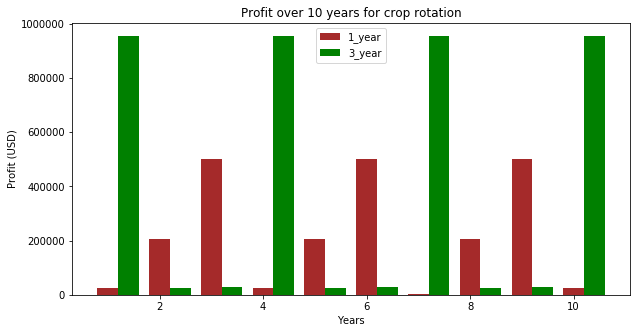

In [17]:
  
fig = plt.figure(figsize = (10, 5))
 
br1 = np.arange(1, len(p1)+1)
br2 = [x + 0.4 for x in br1]

plt.bar(br1, p1, color ='brown', width = 0.4, label ='1_year')
plt.bar(br2, p3, color = 'green', width = 0.4, label ='3_year')
 
plt.xlabel("Years")
plt.ylabel("Profit (USD)")
plt.title("Profit over 10 years for crop rotation")
plt.legend()
plt.show()

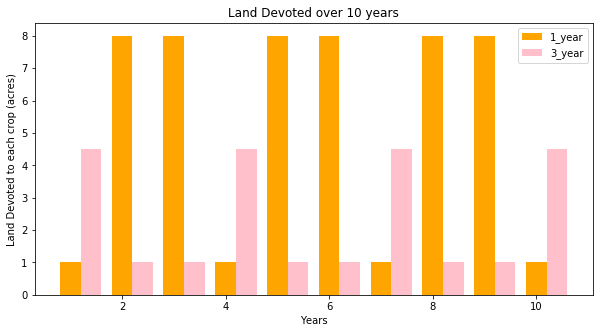

In [18]:
fig1 = plt.figure(figsize = (10, 5))

barWidth = 0.4
br1 = np.arange(1, len(l1)+1)
br2 = [x + barWidth for x in br1]


plt.bar(br1, l1, color ='orange', width = barWidth, label ='1_year')
plt.bar(br2, l3, color ='pink', width = barWidth, label ='3_year')

 
plt.xlabel("Years")
plt.ylabel("Land Devoted to each crop (acres)")
plt.title("Land Devoted over 10 years")
plt.legend()
plt.show()